# Exploratory Data Analysis
#### Import Harry Potter Text and use NTLK for cleaning

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
import pandas as pd

Bookfile = [] # Empty "Book" list - Prepare for loop

# Loops through importing 7 HP text files - Book 1 creates table, Books 2-7 append to Book 1 table
for i in range(1, 8): 
    Bookfile.append('HPBook'+str(i)+'.txt')
    FileLoc = "data/{}".format(Bookfile[i-1])
    if i == 1:
        df = pd.read_csv(FileLoc, sep="@")
    else:
        df2 = pd.read_csv(FileLoc, sep="@")
        df = pd.concat([df, df2])

In [3]:
#using NLTK for text cleaning and analysis 
import nltk 
nltk.download('punkt') 
from nltk import word_tokenize
from nltk.corpus import stopwords 

stopwords = set(stopwords.words('english')) 

import string 

# Function for removing punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] #Remove punctuation from stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\corii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#add a word count for each chapter
df['WordCountText']=df['Text'].str.lower().apply(remove_punctuations).apply(word_tokenize)
df['WordCount'] = df['WordCountText'].str.len() #Word Count Per Chapter
df.reset_index()

,index,Text,Chapter,Book,WordCountText,WordCount
0,0,"THE BOY WHO LIVED Mr. and Mrs. Dursley, of nu...",1,1,"[the, boy, who, lived, mr, and, mrs, dursley, ...",4591
1,1,THE VANISHING GLASS Nearly ten years had pass...,2,1,"[the, vanishing, glass, nearly, ten, years, ha...",3445
2,2,THE LETTERS FROM NO ONE The escape of the Bra...,3,1,"[the, letters, from, no, one, the, escape, of,...",3842
3,3,THE KEEPER OF THE KEYS BOOM. They knocked aga...,4,1,"[the, keeper, of, the, keys, boom, they, knock...",3690
4,4,DIAGON ALLEY Harry woke early the next mornin...,5,1,"[diagon, alley, harry, woke, early, the, next,...",6570
...,...,...,...,...,...,...
195,32,"Harry remained kneeling at Snape's side, simpl...",33,7,"[harry, remained, kneeling, at, snapes, side, ...",7930
196,33,"Finally, the truth. Lying with his face presse...",34,7,"[finally, the, truth, lying, with, his, face, ...",3762
197,34,"He lay facedown, listening to the silence. He ...",35,7,"[he, lay, facedown, listening, to, the, silenc...",4846
198,35,He was flying facedown on the ground again. Th...,36,7,"[he, was, flying, facedown, on, the, ground, a...",6943


#### Create a Corpus and Explore intial Corpus parameters

In [6]:
#make a corpus from the dataframe
corpus = df['Text'].tolist()
corpus_df = pd.DataFrame(corpus, columns=['text'])
tokenized_corpus = [word_tokenize(doc.lower()) for doc in corpus]
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_corpus) #one to one mapping of unique words to unqiue ID 
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_corpus] #create bag of words 

In [7]:
#0a. What is the size of the corpus?
#0b. Are there any duplicates in the corpus? If so, remove or drop them.
# 0c. Are there any missing values in the corpus? If so, what data are missing?
print("Number of rows:", len(corpus_df.index))
print("Number of duplicate rows:", corpus_df.duplicated().sum())
missing_values = corpus_df.isnull().sum()
print(missing_values)

Number of rows: 200
Number of duplicate rows: 0
text    0
dtype: int64


#### Using Spacy 

In [8]:
import spacy
import string
nlp = spacy.load('en_core_web_sm')

In [9]:
punctuation = list(string.punctuation)
corpus_df['tokens'] = corpus_df['text'].progress_apply(lambda x: [x.lemma_.lower() for x in nlp(x) if x.lemma_.lower() not in punctuation])

  0%|          | 0/200 [00:00<?, ?it/s]

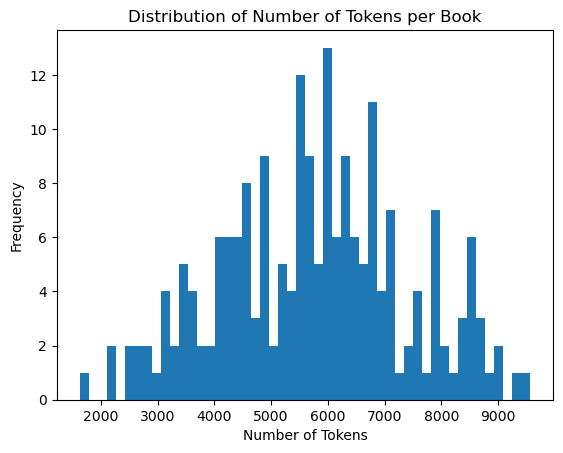

In [10]:
import collections
all_tokens = [token for row in corpus_df['tokens'] for token in row]
token_freq = collections.Counter(all_tokens)
num_tokens = corpus_df['tokens'].apply(len)
plt.hist(num_tokens, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tokens per Book')
plt.show()

In [11]:
# Find the longest chapter
longest_chapter = df.iloc[df['Text'].str.len().idxmax()]
longest_word_count = len(longest_chapter['Text'].split())
print(f"The longest chapter is Chapter {longest_chapter['Chapter']} of Book {longest_chapter['Book']} with {longest_word_count} words.")

# Find the shortest chapter
shortest_chapter = df.iloc[df['Text'].str.len().idxmin()]
shortest_word_count = len(shortest_chapter['Text'].split())
print(f"The shortest chapter is Chapter {shortest_chapter['Chapter']} of Book {shortest_chapter['Book']} with {shortest_word_count} words.")

The longest chapter is Chapter 13 of Book 1 with 3205 words.
The shortest chapter is Chapter 1 of Book 3 with 3728 words.


In [16]:
## 1c. What is the 95th percentile of the number of tokens per document?
pct_95 = np.percentile(df['WordCount'], 95)
pct_95

8051.15

In [17]:
## 1d. What is the size of the vocabulary and the frequencies of each token in the corpus?
from collections import Counter
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)
all_tokens = [token for row in corpus_df['tokens'] for token in row if token not in stop_words]
token_counts = Counter(all_tokens)
print('The size of the vocabulary is ' + str(len(token_counts)))

The size of the vocabulary is 31842


In [18]:
print("The 10 most common tokens and their frequencies are:")
for i, (token, count) in enumerate(token_counts.most_common(10), start=1):
    print(f"{i}. {token.strip():<15} {count}")

The 10 most common tokens and their frequencies are:
1.                 16947
2. harry           16803
3.                 8796
4. ron             5930
5. look            5513
6. hermione        4978
7. know            3777
8. think           3145
9. dumbledore      3093
10. ...             2823


#### Some Graphs for Visualization 

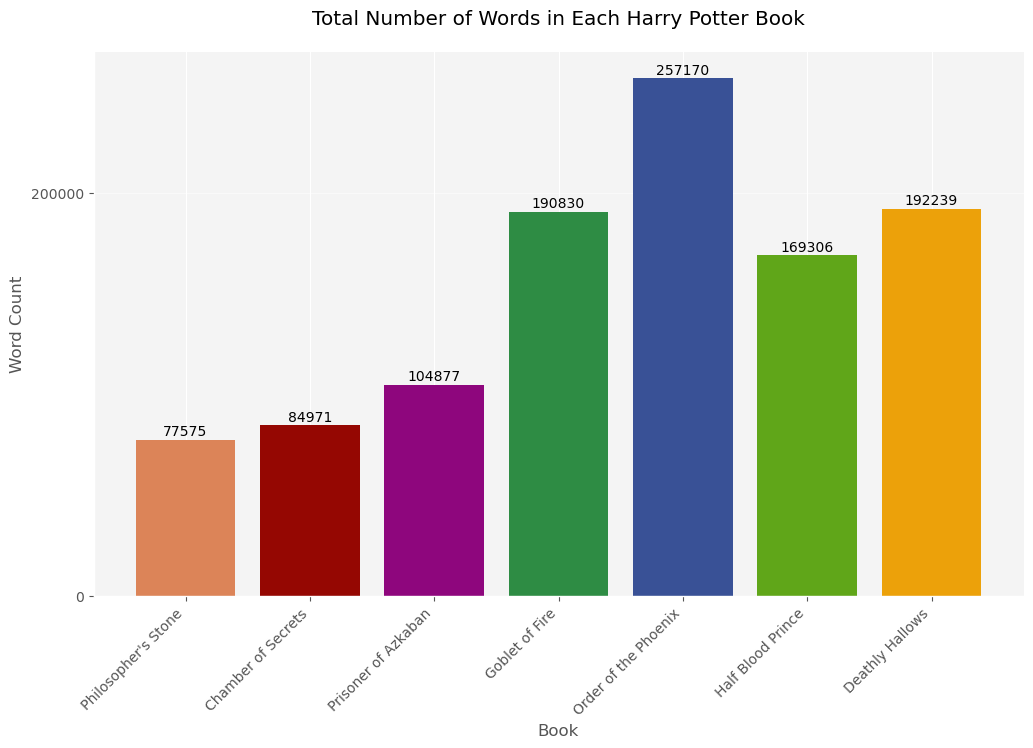

In [19]:
BookTitles=["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",           "Order of the Phoenix", "Half Blood Prince", "Deathly Hallows"]

x = df.groupby(['Book'])['WordCount'].sum().reset_index()['Book']
y = df.groupby(['Book'])['WordCount'].sum().reset_index()['WordCount']
x_pos = np.arange(len(x))

plt.style.use('ggplot')

# Increase figure size
fig = plt.figure(figsize=(12, 8))

# Add buffer to max y value
max_y = max(y) + 50000

# Plot bar chart
barchart = plt.bar(x_pos, y, color=['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'])

plt.xlabel("Book")
plt.ylabel("Word Count")
plt.title("Total Number of Words in Each Harry Potter Book", pad=20)
plt.xticks(x_pos, BookTitles, rotation=45, ha='right')
plt.yticks(np.arange(0, max_y, 200000))

# Add counts above the two bar graphs with more white space above the word count
for bar in barchart:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height+500, '%d' % int(height), ha='center', va='bottom')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid lines and set facecolor of figure
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F4F4F4')

# Adjust figure size and add padding to the bottom
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.subplots_adjust(bottom=0.2)

plt.show()

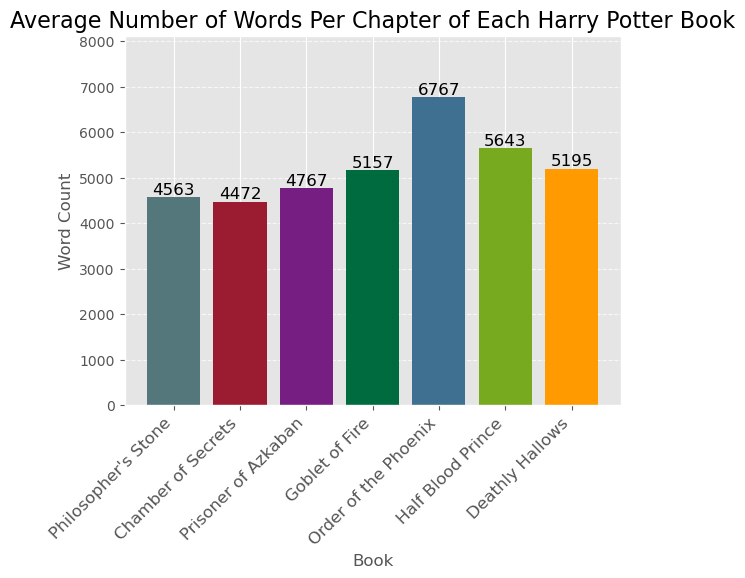

In [20]:
BookTitles=["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",           "Order of the Phoenix", "Half Blood Prince", "Deathly Hallows"]

x = df.groupby(['Book'])['WordCount'].mean().reset_index()['Book']
y = df.groupby(['Book'])['WordCount'].mean().reset_index()['WordCount']
x_pos = np.arange(len(x))
plt.style.use('ggplot')
barchart = plt.bar(x_pos, y, color=['#53777A', '#9B1B30', '#771E82', '#006B3F', '#3F6F91', '#77AA1E', '#FF9A00'])
plt.xlabel("Book")
plt.ylabel("Word Count")
plt.title("Average Number of Words Per Chapter of Each Harry Potter Book", fontsize=16)
plt.xticks(x_pos, BookTitles, rotation=45, ha="right", fontsize=12)
plt.ylim(ymin=0, ymax=max(y)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts above the two bar graphs
for bar in barchart:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=12)

plt.show()

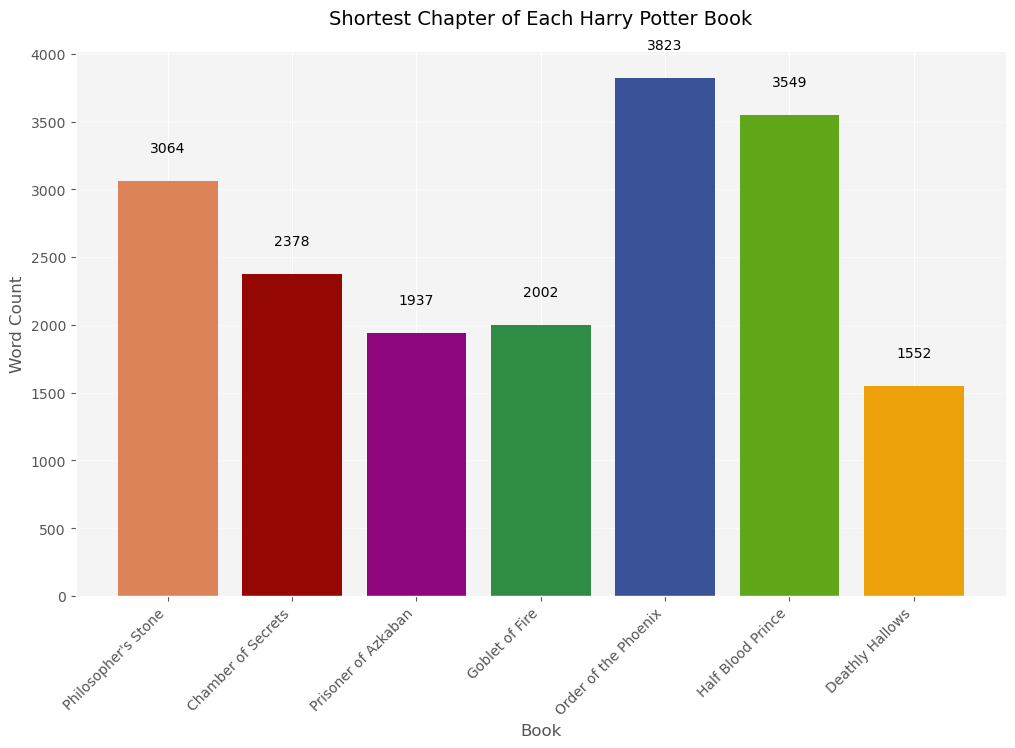

In [21]:
BookTitles=["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",
           "Order of the Phoenix", "Half Blood Prince", "Deathly Hallows"]

x = df.groupby(['Book'])['WordCount'].min().reset_index()['Book']
y = df.groupby(['Book'])['WordCount'].min().reset_index()['WordCount']
x_pos = np.arange(len(x))
plt.style.use('ggplot')
barchart=plt.bar(x_pos, y, color=['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'])
plt.xlabel("Book", fontsize=12)
plt.ylabel("Word Count", fontsize=12)
plt.title("Shortest Chapter of Each Harry Potter Book", fontsize=14, pad=20)
plt.xticks(x_pos, BookTitles, rotation=45, ha='right', fontsize=10)

# Add counts above the two bar graphs with some buffer space
buffer = max(y) * 0.05
for bar in barchart:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height+buffer, '%d' % int(height), ha='center', va='bottom', fontsize=10)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid lines and set facecolor of figure
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F4F4F4')

# Adjust figure size and add padding to the bottom
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.subplots_adjust(bottom=0.2)

plt.show()